In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
train_data_path = './data_train.npz'
val_data_path = './data_val.npz'
test_data_path = './data_test.npz'

data_train = np.load(train_data_path, allow_pickle=True)
px = data_train['ParticleMomentum'][:,0]
py = data_train['ParticleMomentum'][:,1]
pz = data_train['ParticleMomentum'][:,2]
Energy = np.sqrt(np.square(px)+np.square(py)+np.square(pz))
Alpha = np.arctan2(py, px)
Theta = np.arctan2(pz, np.sqrt(np.square(px)+np.square(py)))
new_momentum = np.stack((Energy, Alpha, Theta), axis=-1)
print(list(data_train.keys()))
N = int(len(data_train['EnergyDeposit'])*0.9)
# [data_size, 900]
EnergyDeposit = data_train['EnergyDeposit'][:N]
# reshaping it as [data_size, channels, img_size_x, img_size_y]
# channels are needed for pytorch conv2d-layers
EnergyDeposit = EnergyDeposit.reshape(-1, 1, 30, 30)
for i in range(30):
    for j in range(30):
        res = 0
        for k in range(N):
            res += EnergyDeposit[k, 0, i, j]
        print(i, j, res)
# [data_size, 3]
# ParticleMomentum = data_train['ParticleMomentum'][:N]
ParticleMomentum = new_momentum[:N,:]
# [data_size, 2]
ParticlePoint = data_train['ParticlePoint'][:, :2][:N]
# [data_size, 1]
ParticlePDG = data_train['ParticlePDG'][:N]

EnergyDeposit_val = data_train['EnergyDeposit'][N:]
EnergyDeposit_val = EnergyDeposit_val.reshape(-1, 1, 30, 30)
# ParticleMomentum_val = data_train['ParticleMomentum'][N:]
ParticleMomentum_val = new_momentum[N:]
ParticlePoint_val = data_train['ParticlePoint'][:, :2][N:]
ParticlePDG_val = data_train['ParticlePDG'][N:]
#EnergyDeposit_val = torch.tensor(EnergyDeposit_val).float()
ParticleMomentum_val = torch.tensor(ParticleMomentum_val).float()
ParticlePoint_val = torch.tensor(ParticlePoint_val).float()

EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()

BATCH_SIZE = 256
calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
    break

TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN']

TASK = 'WASSERSTEIN'

LIPSITZ_WEIGHTS = False
clamp_lower, clamp_upper = -0.01, 0.01


# https://arxiv.org/abs/1704.00028
GRAD_PENALTY = True

# https://arxiv.org/abs/1705.09367
ZERO_CENTERED_GRAD_PENALTY = False
# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = True

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

class GANLosses(object):
    def __init__(self, task, device):
        self.TASK = task
        self.device = device
    
    def g_loss(self, discrim_output):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - discrim_output.mean()
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        return loss

    def calc_gradient_penalty(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = 10):
        alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
        dims_to_add = len(inp_data.size()) - 2
        for i in range(dims_to_add):
            alpha = alpha.unsqueeze(-1)
        # alpha = alpha.expand(inp_data.size())

        interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

        interpolates.requires_grad = True

        disc_interpolates = discriminator(interpolates, inputs_batch)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
        clear_output()
        print(gradient_penalty)
        print(gradients.shape)
        print(gradients[0][0])
        return gradient_penalty
        sleep(10)
    def calc_gradient_penalty_cpu(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = 10):
        alpha = torch.rand(inp_data.shape[0], 1)
        dims_to_add = len(inp_data.size()) - 2
        for i in range(dims_to_add):
            alpha = alpha.unsqueeze(-1)
        # alpha = alpha.expand(inp_data.size())

        interpolates = (alpha * inp_data + ((1 - alpha) * data_gen))

        interpolates.requires_grad = True

        disc_interpolates = discriminator(interpolates, inputs_batch)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 
        
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=2)
        self.dropout = nn.Dropout(p=0.3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        
        # size
        self.fc1 = nn.Linear(4096 + 5, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        EnergyDeposit = self.dropout(F.leaky_relu(self.conv1(EnergyDeposit)))
        EnergyDeposit = self.dropout(F.leaky_relu(self.conv2(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv4(EnergyDeposit)) # 32, 9, 9
        EnergyDeposit = EnergyDeposit.view(len(EnergyDeposit), -1)
        
        t = torch.cat([EnergyDeposit, ParticleMomentum_ParticlePoint], dim=1)
        
        t = F.leaky_relu(self.fc1(t))
        t = F.leaky_relu(self.fc2(t))
        t = F.leaky_relu(self.fc3(t))
        return torch.sigmoid(self.fc4(t))
        
NOISE_DIM = 10
class ModelGConvTranspose(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim + 2 + 3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 4096)
        
        self.conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2, output_padding=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1)
        
        
        self.conv4 = nn.Conv2d(32, 1, 3)
        
        
    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = F.leaky_relu(self.fc1(
            torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        ))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        
        EnergyDeposit = x.view(-1, 256, 4, 4)
        
        EnergyDeposit = F.leaky_relu(self.conv1(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv2(EnergyDeposit))
        EnergyDeposit = F.leaky_relu(self.conv3(EnergyDeposit))
        EnergyDeposit = self.conv4(EnergyDeposit)
#         EnergyDeposit = torch.tanh(EnergyDeposit)

        return EnergyDeposit

discriminator = ModelD().to(device)
generator = ModelGConvTranspose(z_dim=NOISE_DIM).to(device)

EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                       ParticleMomentum_b.to(device), \
                                                       ParticlePoint_b.to(device)
ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

print(EnergyDeposit_b.shape)
print(discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape)
noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
print(generator(noise, ParticleMomentum_ParticlePoint_b).shape)


import math
def get_centrality(EnergyDeposit):
    thresholds = [2, 4, 6, 8, 10, 12, 14]
    result = np.zeros((len(EnergyDeposit), 7))
    EnergyDeposit = np.asarray(EnergyDeposit)
    for i in range(30):
        for j in range(30):
            dist = math.sqrt((i - 15)**2 + (j - 15)**2)
            for k in range(min(7, int(dist/2) + 1)):
                result[:,k] += EnergyDeposit[:,i,j]
                #print(result[0])
    return result  

def get_hist_diff(EnergyDeposit):
    EnergyDeposit = np.log10(np.maximum(0.01, EnergyDeposit))
    result = np.zeros((len(EnergyDeposit), 5))
    for i in range(5):
        result[:, i] = np.sum(np.where((EnergyDeposit >= -2+i) & (EnergyDeposit < -1+i), 1, 0), axis=(1, 2))
    return result


# learning_rate_dis = 0.0002
# learning_rate_gen = 0.00002
learning_rate_dis = 0.0002
learning_rate_gen = 0.001

lr_lambda = lambda x: math.exp(x * math.log(1e-3) / (3000 * len(calo_dataloader)))

g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)
scheduler = optim.lr_scheduler.LambdaLR(d_optimizer, lr_lambda)
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005)
#d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00001, weight_decay=1e-2)
# d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)
# g_optimizer = optim.Adam(generator.parameters())
# d_optimizer = optim.Adam(discriminator.parameters())

from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

# noise_long = torch.randn(1280000, 10).to(device)


cuda
['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']
0 0 5045.304635179933
0 1 5548.322469275635
0 2 6493.254379856575
0 3 7273.964828623301
0 4 8433.448328482502
0 5 9427.926014848295
0 6 10210.435648963748
0 7 11679.883741286994
0 8 12688.85991851263
0 9 13610.52213809452
0 10 15164.753197740169
0 11 15713.427852897285
0 12 16313.61184530183
0 13 16574.45676537719
0 14 17182.646264321924
0 15 17131.765886982408
0 16 17327.65664465305
0 17 16382.20170403183
0 18 15571.529456817056
0 19 14893.835299207065
0 20 13957.529488846887
0 21 12329.756475417616
0 22 11657.057145235502
0 23 10688.91596213337
0 24 9265.451670925904
0 25 8308.296981403686
0 26 7327.035501888337
0 27 6422.373421056469
0 28 5651.388930985149
0 29 5027.096373188899
1 0 5588.806641384279
1 1 6357.517979424509
1 2 7425.261449690532
1 3 8404.43298907768
1 4 9716.312577078528
1 5 11378.559114608355
1 6 12436.973328327815
1 7 14055.228428601125
1 8 15489.76781425392
1 9 17309.958819345375
1 10 18857.

11 26 36464.75249520781
11 27 27672.13673526803
11 28 21366.038114608655
11 29 16597.892980723227
12 0 16733.266607082827
12 1 21689.575979228463
12 2 28160.009934869417
12 3 37631.12806772603
12 4 51355.34085577499
12 5 71271.03996077483
12 6 102156.42805678624
12 7 148415.73372660164
12 8 221116.5221320894
12 9 328308.7608077766
12 10 494741.1165009516
12 11 748840.1738386658
12 12 1143303.9226073772
12 13 1504012.6336426775
12 14 1654122.3609318957
12 15 1662717.9237418538
12 16 1479135.7428970367
12 17 1132821.330383862
12 18 742364.1923951108
12 19 491771.21596301947
12 20 325955.8999346632
12 21 219570.49549753347
12 22 149817.20410770606
12 23 103380.90541079921
12 24 73062.10274540853
12 25 53188.26004734383
12 26 38716.5828487481
12 27 29317.493739335157
12 28 22240.762180229205
12 29 17211.966802435818
13 0 17356.587898835693
13 1 22212.854334808042
13 2 29879.42623232374
13 3 39967.551894280106
13 4 55877.676032826734
13 5 77539.84315944843
13 6 111368.25201722342
13 7 16281

23 12 102605.13192702053
23 13 109784.28194859327
23 14 116701.16237774037
23 15 113445.28716654473
23 16 107809.80147721691
23 17 100209.93156395921
23 18 89157.12518203096
23 19 77036.11106253747
23 20 62151.234807147935
23 21 51666.12502432182
23 22 43047.22174565187
23 23 34400.05005478764
23 24 27430.30117673646
23 25 22056.171526368318
23 26 18401.61260870421
23 27 14922.998395408955
23 28 12440.895886131502
23 29 10255.813226077187
24 0 9198.068554109364
24 1 11005.604291091486
24 2 13341.215827070404
24 3 16309.71886073187
24 4 19497.813805821475
24 5 23709.75951980167
24 6 28690.01088239542
24 7 33953.57372998632
24 8 41149.38629472359
24 9 49450.8855614195
24 10 56707.32917305951
24 11 65752.02764314682
24 12 71945.85580370396
24 13 76245.54950371005
24 14 80121.02434657811
24 15 78037.93611119897
24 16 75620.00811673976
24 17 70435.69699191274
24 18 64355.52705703441
24 19 56461.412692641825
24 20 47233.144482138734
24 21 39179.288970807094
24 22 33097.55340034262
24 23 2820

In [13]:
full_model = torch.load('./1-1_sgd_nonorm_10')
generator.load_state_dict(full_model['weights_gen'])
discriminator.load_state_dict(full_model['weights_dis'])
g_optimizer.load_state_dict(full_model['g_optimizer'])

In [14]:
import timeit
def run_training(epochs, num, EnergyDeposit_val, k_d, k_g):

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    cur_epoch = 0
#     k_d, k_g = 0, 1
    
    gan_losses = GANLosses(TASK, device)
    dis_epoch_loss = []
    gen_epoch_loss = []
    predictions_dis = []
    predictions_gen = []
    prd_auc = []  
    for epoch in tqdm(range(epochs)):
        first = True
        cur_noise = 0
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device)
            EnergyDeposit_tanh = EnergyDeposit_b
#             EnergyDeposit_tanh = torch.log(1+EnergyDeposit_b)
            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
            if first:
                noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                predictions_dis.append(
                    list(discriminator(EnergyDeposit_tanh, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )

                predictions_gen.append(
                    list(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b).detach().cpu().numpy().ravel())
                )
            # Optimize D
            loss = 0.0
            for _ in range(k_d):
#                 start = timeit.default_timer()
                noise = torch.randn(len(EnergyDeposit_tanh), NOISE_DIM).to(device)
#                 noise = noise_long[cur_noise:cur_noise+128,:]
#                 cur_noise += 128
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
#                 st1 = timeit.default_timer()
    
                if INSTANCE_NOISE:
                    EnergyDeposit_tanh = add_instance_noise(EnergyDeposit_tanh)
                    EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
#                 st2 = timeit.default_timer()
                loss = gan_losses.d_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b),
                                         discriminator(EnergyDeposit_tanh, ParticleMomentum_ParticlePoint_b))
                
                if GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_gradient_penalty(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_tanh.data)
                    loss += grad_penalty
                    
                elif ZERO_CENTERED_GRAD_PENALTY:
                    grad_penalty = gan_losses.calc_zero_centered_GP(discriminator,
                                                                    EnergyDeposit_gen.data,
                                                                    ParticleMomentum_ParticlePoint_b,
                                                                    EnergyDeposit_tanh.data)
                    loss -= grad_penalty

                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
                if LIPSITZ_WEIGHTS:                    
                    [p.data.clamp_(clamp_lower, clamp_upper) for p in discriminator.parameters()]
#                 print(st1 - start, st2-st1)

            if k_d > 0:
                dis_epoch_loss.append(loss.item())

            # Optimize G
            for _ in range(k_g):
                noise = torch.randn(len(EnergyDeposit_tanh), NOISE_DIM).to(device)
                EnergyDeposit_gen = generator(noise, ParticleMomentum_ParticlePoint_b)
                
                if INSTANCE_NOISE:
                    EnergyDeposit_tanh = add_instance_noise(EnergyDeposit_tanh)
                    EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
                
                loss = gan_losses.g_loss(discriminator(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_b))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            if k_g > 0:
                gen_epoch_loss.append(loss.item())
#             if first:
#                 precision, recall = compute_prd_from_embedding(
#                     EnergyDeposit_gen.detach().cpu().numpy().reshape(BATCH_SIZE, -1), 
#                     EnergyDeposit_b.detach().cpu().numpy().reshape(BATCH_SIZE, -1),
#                     num_clusters=30,
#                     num_runs=100)
#                 prd_auc.append(auc(precision, recall))
#                 first = False
        
        #to_save = {'weights_gen': generator.state_dict(), 'weights_dis': discriminator.state_dict(), 'd_optimizer': d_optimizer.state_dict(), 'g_optimizer': g_optimizer.state_dict(), 'epoch': cur_epoch}
        #torch.save(to_save, './17')
        noise = torch.randn(500, NOISE_DIM) #len(ParticleMomentum)
        ParticleMomentum_ParticlePoint_val = torch.cat([ParticleMomentum_val[:500], 
                                                    ParticlePoint_val[:500]], dim=1)
        ParticleMomentum_ParticlePoint_train = torch.cat([ParticleMomentum[:500], 
                                                    ParticlePoint[:500]], dim=1)
        generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
        generator_cpu.load_state_dict(generator.state_dict())
        generator_cpu.eval()
        discriminator_cpu = ModelD()
        discriminator_cpu.load_state_dict(discriminator.state_dict())
        discriminator_cpu.eval()
        EnergyDeposit_val_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint_val)
        #EnergyDeposit_train_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint_train)
        EnergyDeposit_val_tensor = torch.tensor(EnergyDeposit_val[:500]).float()
        disc_gen = discriminator_cpu(EnergyDeposit_val_gen, ParticleMomentum_ParticlePoint_val)
        disc_real = discriminator_cpu(EnergyDeposit_val_tensor, ParticleMomentum_ParticlePoint_val)
        dloss = gan_losses.d_loss(disc_gen, disc_real)
        gloss = gan_losses.g_loss(disc_gen)
        if GRAD_PENALTY:
            grad_penalty = gan_losses.calc_gradient_penalty_cpu(discriminator_cpu,
                                                            EnergyDeposit_val_gen.data,
                                                            ParticleMomentum_ParticlePoint_val,
                                                            EnergyDeposit_val_tensor.data)
            dloss += grad_penalty
        disc_gen = disc_gen.detach().numpy()
        disc_real = disc_real.detach().numpy()
        clear_output(wait=True)
#         plt.figure(figsize=(25, 12))
#         plt.xlim(-0.25,0.25)
#         plt.ylim(0,100)
# #         print(disc_gen[:500])
# #         print(disc_real[:500])
#         plt.hist(disc_gen, bins=30, color='red')
#         plt.hist(disc_real, bins=30, color='blue')
#         plt.xlabel('Discriminator output')
#         plt.title('Blue - real, Red - generated')
        plt.figure(figsize=(12, 12))
        plt.hist(disc_real, bins=100, label='dis_epoch_loss')
        plt.hist(disc_gen, bins=100, label='gen_epoch_loss')
        plt.legend()
#         if not os.path.exists('./images/%d' % (num)):
#             os.makedirs('./images/%d' % (num))
#         plt.savefig('./images/%d/%d.png' % (num, cur_epoch))
        EnergyDeposit_val_gen = EnergyDeposit_val_gen.detach().cpu().numpy().reshape(-1, 30, 30)
        print(type(EnergyDeposit_val))
        EnergyDeposit_tensor = EnergyDeposit_val[:500].reshape(-1, 30, 30)
        print(type(EnergyDeposit_tensor))
        centrality = get_centrality(EnergyDeposit_tensor[:500])
        centrality_gen = get_centrality(EnergyDeposit_val_gen)
        error = np.mean(np.sum(np.square(centrality - centrality_gen)/np.square(centrality), axis=1))
        error_diff = np.mean(np.sum(np.abs(centrality - centrality_gen), axis=1)/np.sum(centrality, axis=1))
        print(type(EnergyDeposit_tensor), type(EnergyDeposit_val_gen))
        error_pixel = np.mean(np.square(EnergyDeposit_tensor[:500] - EnergyDeposit_val_gen))
        error_hist_diff = np.mean(np.sum(np.abs(get_hist_diff(EnergyDeposit_tensor[:500]) - get_hist_diff(EnergyDeposit_val_gen)), axis=1))
        error_sum_gen = np.mean(np.sum(EnergyDeposit_val_gen, axis=(1, 2)))
        cur_epoch += 1
        lr = 0
        for param_group in d_optimizer.param_groups:
            lr += param_group['lr']
        #file = open('./sgd-1/'+str(num), 'a')
        #file.write('Epoch lr=%.9f %.d - %.4f, %.4f, pixel:%.4f, hist:%.4f, sum:%.4f, test: d_loss  %.4f, g_loss  %.4f, real  %.4f, gen  %.4f\n' % (lr, cur_epoch, error, error_diff, error_pixel, error_hist_diff, error_sum_gen, dloss, gloss, np.mean(disc_real), np.mean(disc_gen)))
#         np.mean(gen_epoch_loss[-1]), np.mean(gen_epoch_loss[-1]), np.mean(predictions_gen[-1]), np.mean(predictions_gen[-1]) , train: d_loss  %.4f, g_loss  %.4f, real %.4f, gen  %.4f
        #file.close()
        clear_output(wait=True)
        plt.figure(figsize=(12, 12))
        plt.plot(dis_epoch_loss, label='dis_epoch_loss')
        plt.plot(gen_epoch_loss, label='gen_epoch_loss')
        plt.legend()
        plt.show()
        plt.figure(figsize=(12, 12))
#         plt.hist(predictions_dis[-1], bins=100, label='dis_epoch_loss')
        plt.hist(predictions_gen[-1], bins=100, label='gen_epoch_loss')
        plt.legend()
        plt.show()
#         print(np.mean(predictions_dis[-1]), np.mean(predictions_gen[-1]))
        plt.figure(figsize=(12, 12))
        plt.plot(prd_auc, label='prd_auc')
        plt.plot()
        plt.legend()
        plt.show()
    return np.mean(predictions_gen[-1])

In [15]:
run_training(3000, 31, EnergyDeposit_val, 5, 1)

tensor(10.0000, device='cuda:0', grad_fn=<MulBackward>)
torch.Size([256, 1, 30, 30])
tensor([[ 6.7928e-07, -3.8928e-07,  1.6839e-06, -5.8514e-06,  1.8752e-06,
         -2.2069e-06, -4.0391e-07, -2.5100e-06,  3.5620e-06, -5.3897e-07,
         -5.0541e-09, -1.1534e-06,  5.8855e-08, -4.6719e-06,  9.6242e-07,
          7.2288e-07, -8.8345e-08,  3.0324e-06,  2.6635e-06,  2.1204e-06,
         -1.7135e-06, -5.7783e-06,  2.7510e-06,  8.3985e-07, -2.6220e-07,
          2.4200e-06, -1.1399e-07, -2.6876e-06,  2.3888e-06,  3.2238e-06],
        [ 8.5926e-07, -1.1449e-06, -2.8812e-06,  7.9867e-06,  4.5119e-06,
          3.0941e-06,  5.6616e-06,  1.2542e-08,  1.1941e-06,  1.8642e-06,
          3.6769e-07,  3.5232e-06, -5.5540e-07, -2.1698e-07,  3.8663e-06,
          2.0781e-06, -1.7481e-06, -4.8653e-07, -2.3593e-06, -1.3095e-06,
          8.8959e-07,  3.4718e-06, -3.0834e-07, -2.2733e-06,  4.0855e-07,
         -3.1420e-06,  7.5513e-07,  5.5024e-06, -2.5224e-06,  6.5181e-07],
        [-3.1646e-06,  4.

  0%|          | 0/3000 [00:05<?, ?it/s]


KeyboardInterrupt: 

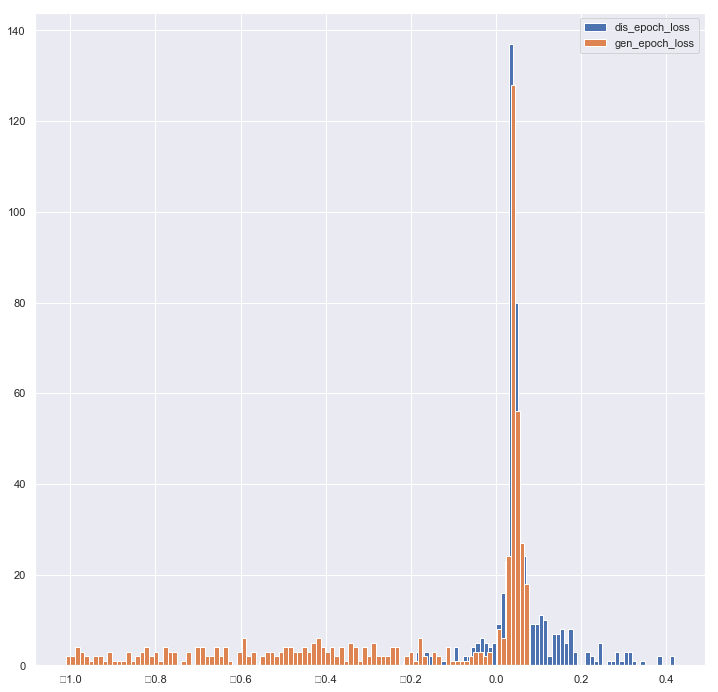

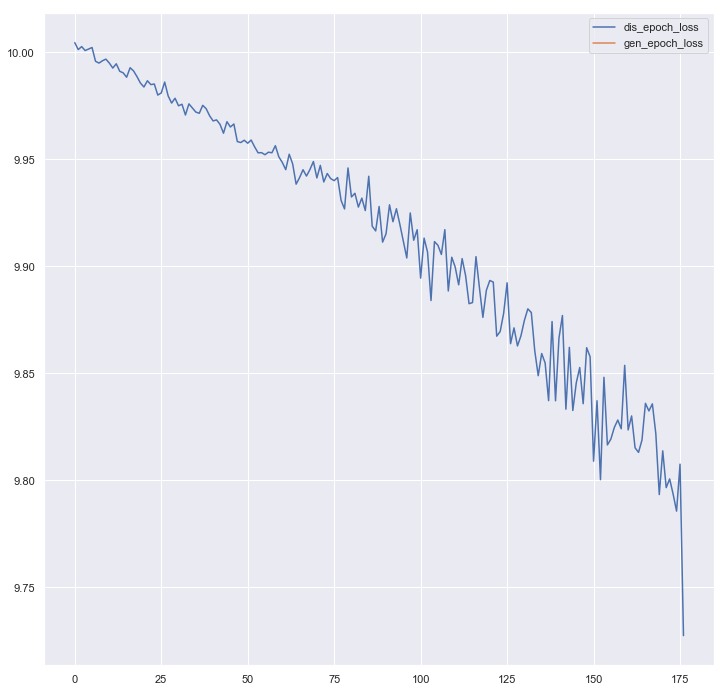

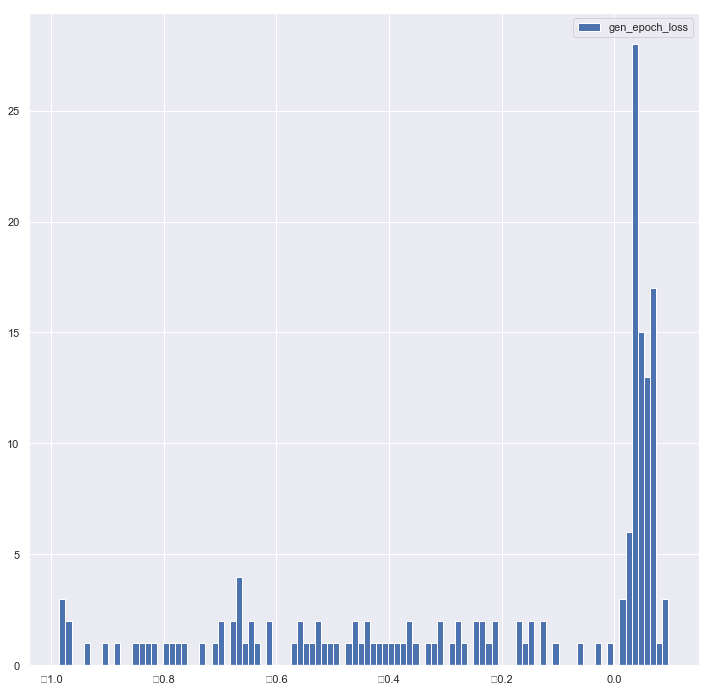

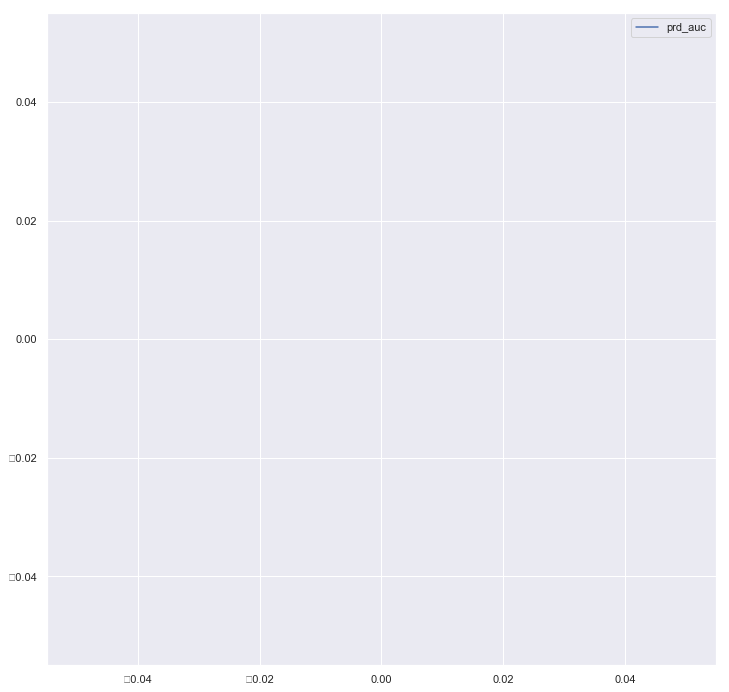







  7%|▋         | 1/15 [01:50<25:43, 110.25s/it]

In [ ]:
full_model = torch.load('./1-1_sgd_nonorm_10')
generator.load_state_dict(full_model['weights_gen'])
discriminator = ModelD().to(device)
learning_rate_dis = 0.0004
learning_rate_gen = 0.001
lr_lambda = lambda x: math.exp(x * math.log(1e-3) / (3000 * len(calo_dataloader)))
d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)
scheduler = optim.lr_scheduler.LambdaLR(d_optimizer, lr_lambda)
g_optimizer.load_state_dict(full_model['g_optimizer'])
run_training(15, 24, EnergyDeposit_val, 1, 0)

In [ ]:
run_training(50, 24, EnergyDeposit_val, 0, 1)

In [2]:
generator.load_state_dict(torch.load('./gan2.pt'))

In [14]:
full_model = torch.load('./e-3_hist_dif')
generator.load_state_dict(full_model['weights_gen'])
generator.to(device)
discriminator.load_state_dict(full_model['weights_dis'])
discriminator.to(device)
d_optimizer.load_state_dict(full_model['d_optimizer'])
g_optimizer.load_state_dict(full_model['g_optimizer'])
generator.train()
discriminator.train()
cur_epoch = full_model['epoch']
print("ok")

ok


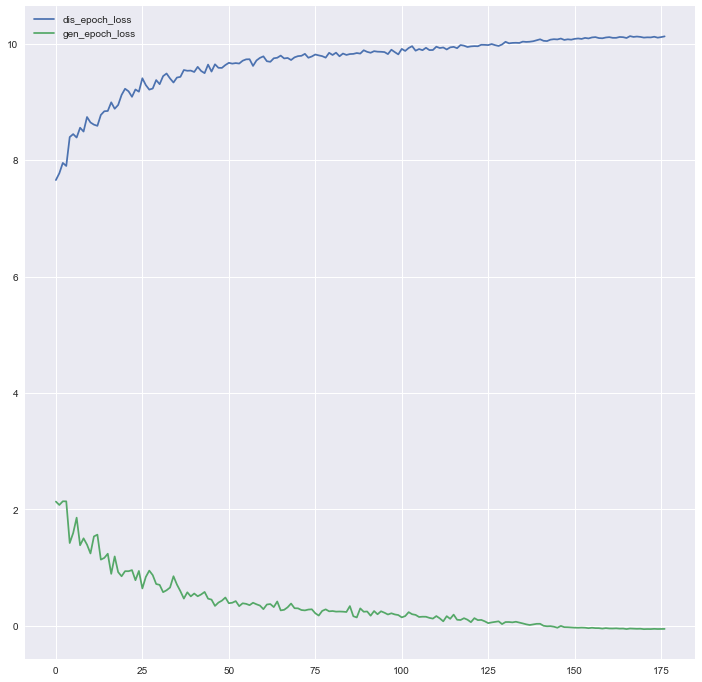

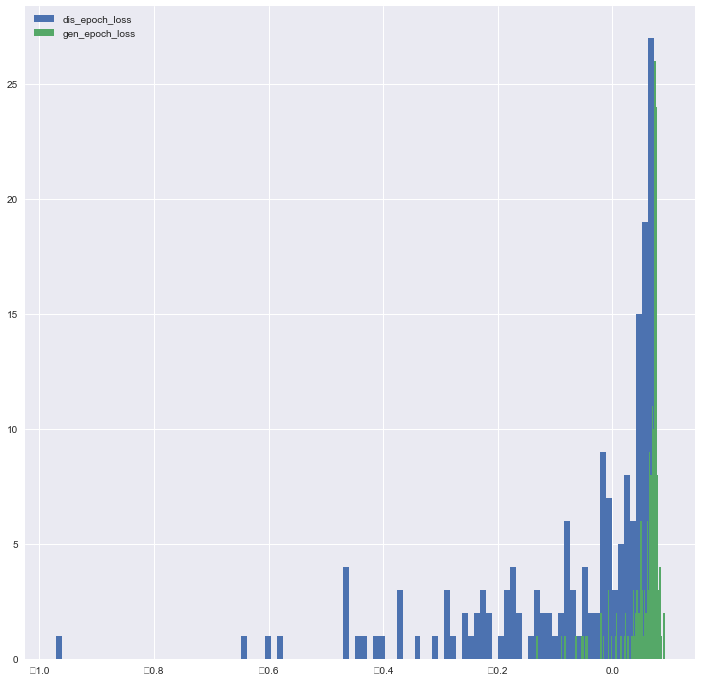

-0.0702464 0.0545358


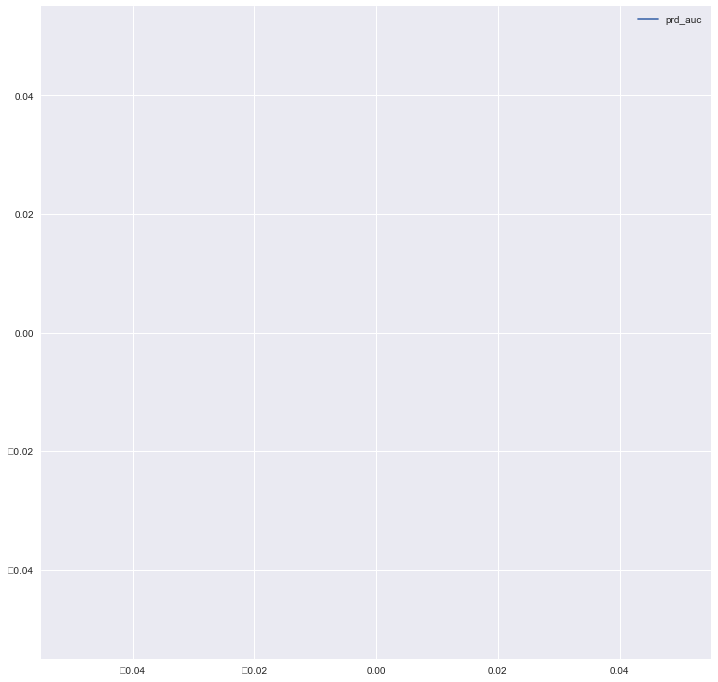

  0%|          | 0/1 [00:00<?, ?it/s]

ok


KeyboardInterrupt: 

In [2]:
from math import sqrt
def get_centrality(EnergyDeposit):
    thresholds = [2, 4, 6, 8, 10, 12, 14]
    result = np.zeros((len(EnergyDeposit), 7))
    EnergyDeposit = np.asarray(EnergyDeposit)
    for i in range(30):
        for j in range(30):
            dist = sqrt((i - 15)**2 + (j - 15)**2)
            for k in range(min(7, int(dist/2) + 1)):
                result[:,k] += EnergyDeposit[:,i,j]
                #print(result[0])
    return result  

def get_hist_diff(EnergyDeposit):
    EnergyDeposit = np.log10(np.maximum(0.01, EnergyDeposit))
    result = np.zeros((len(EnergyDeposit), 5))
    for i in range(5):
        result[:, i] = np.sum(np.where((EnergyDeposit >= -2+i) & (EnergyDeposit < -1+i), 1, 0), axis=(1, 2))
    return result


while (1):
    pred_dis, pred_gen = run_training(1)
    to_save = {'weights_gen': generator.state_dict(), 'weights_dis': discriminator.state_dict(), 'd_optimizer': d_optimizer.state_dict(), 'g_optimizer': g_optimizer.state_dict(), 'epoch': cur_epoch}
    torch.save(to_save, './1-1_adam_nonorm_10')
    noise = torch.randn(300, NOISE_DIM) #len(ParticleMomentum)
    ParticleMomentum_ParticlePoint = torch.cat([ParticleMomentum_val[:300], 
                                                ParticlePoint_val[:300]], dim=1)
    generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
    generator_cpu.load_state_dict(generator.state_dict())
    generator_cpu.eval()
    EnergyDeposit_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint)
#     EnergyDeposit_gen = np.exp(EnergyDeposit_gen.detach().cpu().numpy().reshape(-1, 30, 30)) - 1
    EnergyDeposit_gen = EnergyDeposit_gen.detach().cpu().numpy().reshape(-1, 30, 30)
    EnergyDeposit_val = EnergyDeposit_val.reshape(-1, 30, 30)
    centrality = get_centrality(EnergyDeposit_val[:300])
    centrality_gen = get_centrality(EnergyDeposit_gen)
    error = np.mean(np.sum(np.square(centrality - centrality_gen)/np.square(centrality), axis=1))
    error_diff = np.mean(np.sum(np.abs(centrality - centrality_gen), axis=1)/np.sum(centrality, axis=1))
    error_pixel = np.mean(np.square((EnergyDeposit_val[:300] - EnergyDeposit_gen)))
    error_hist_diff = np.mean(np.sum(np.abs(get_hist_diff(EnergyDeposit_val[:300]) - get_hist_diff(EnergyDeposit_gen)), axis=1))
    error_sum_gen = np.mean(np.sum(EnergyDeposit_gen, axis=(1, 2)))
    cur_epoch += 1
    file = open('./all_adam', 'a')
    file.write('Epoch %.d - %.4f, %.4f, pixel:%.4f, hist:%.4f, sum:%.4f, %.4f, %.4f\n' % (cur_epoch, error, error_diff, error_pixel, error_hist_diff, error_sum_gen, pred_dis, pred_gen))
    file.close()
    print('ok')